In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.base import copy
%matplotlib inline

In [2]:
def standard_scaler(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    norm = lambda x: (x - mean) / std
    inv_norm = lambda norm_x: norm_x * std + mean
    return norm(data), norm, inv_norm

# Error functions
def MSE(y, y_predict):
    return np.mean((y.ravel() - y_predict.ravel())**2)

def RMSE(y, y_predict):
    return np.sqrt(MSE(y, y_predict))

def neg_rmse(y, y_predict):
    return -RMSE(y, y_predict)

def MAE(y, y_predict):
    y = y.ravel()
    y_predict = y_predict.ravel()
    return np.mean(np.abs(y - y_predict))

def MRE(y, y_predict):
    y = y.ravel()
    y_predict = y_predict.ravel()
    return np.mean(np.abs((y - y_predict) / y))

def accurracy(y, y_predict):
    return np.count_nonzero(y.ravel() == y_predict.ravel()) / len(y)    

In [3]:
def kfold_validation(model, x, y, scorer, n_folds=5, add_bias=False, random_state=42, norm_x=False, norm_y=False, plot_loss=False, print_metrics={}):
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    results = []
    
    for i, (train_index, test_index) in enumerate(kfold.split(x)):
        # get data
        fold_x_train, fold_x_test = x[train_index], x[test_index]
        fold_y_train, fold_y_test = y[train_index], y[test_index]

        # norm
        if(norm_x):
            fold_x_train, norm_x, _ = standard_scaler(fold_x_train)
            fold_x_test = norm_x(fold_x_test)
        
        if(add_bias):
            fold_x_train = np.c_[fold_x_train, np.ones(len(fold_x_train))]
            fold_x_test = np.c_[fold_x_test, np.ones(len(fold_x_test))]
        
        if(norm_y):
            fold_y_train, _, inv_norm = standard_scaler(fold_y_train)


        # Train
        model.fit(fold_x_train, fold_y_train.ravel())
        if(plot_loss):
            plt.plot(model.loss_curve_, label=f'Fold {i+1}')
        
        # Predict
        fold_y_predict = model.predict(fold_x_test)
        if(norm_y):
            fold_y_predict = inv_norm(fold_y_predict)
        
        if(len(print_metrics) != 0):
            print(f'Fold {i+1}')
            for metric, metric_function in print_metrics.items():
                value = metric_function(fold_y_test,fold_y_predict)
                print(f'{metric}: {value}')
            print()
        
        results.append(scorer(fold_y_test , fold_y_predict))
    if(plot_loss):
        plt.legend();
    return np.array(results).mean() 

In [4]:
class RandomSearch():
    
    def __init__(self, model, search_params, default_params, random_state=42):
        self.base_model = model
        self.search_params = search_params
        self.default_params = default_params
        self.random_state = random_state
        np.random.seed(self.random_state)
    
    def fit(self, x, y, n_iter=10, **kargs):
        self.scores = []
        self.tested_params = []
        for i in range(n_iter):
            params = {}
            for param, (base, values) in self.search_params.items():
                if(base > 0):
                    params[param] = base ** np.random.randint(
                        low=values[0],
                        high=values[1]
                    )
                else:
                    params[param] = np.random.choice(values)
            
            model = self.base_model(
                random_state=self.random_state,
                **params,
                **default_params
            )
            score = kfold_validation(model, x, y, random_state=self.random_state, **kargs)
            self.scores.append(score)
            self.tested_params.append(params)
        
        self.scores = np.array(self.scores)
        self.tested_params = np.array(self.tested_params)
        self.best_params = self.tested_params[self.scores.argmax()]
        self.best_estimator = self.base_model(
            random_state=self.random_state,
            **self.best_params, 
            **self.default_params
        )
    
    def get_scores_(self):
        return pd.DataFrame(list(zip(self.scores, self.tested_params)), columns=['Score', 'Params'])


## MLPRegressor - Concrete Dataset

In [5]:
concrete = np.genfromtxt('./concrete.csv', delimiter=',')
X = concrete[:, :-1]
Y = concrete[:, [-1]]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
x_train.shape, x_test.shape, X.shape

((824, 8), (206, 8), (1030, 8))

In [6]:
params = {
    'hidden_layer_sizes': (2, [4, 9]),
    'learning_rate_init': (10, [-3, -1]),
    'alpha': (10, [-6, -3]),
}

default_params = {
    'max_iter': 1000,
    'batch_size': 32,
    'solver': 'sgd',
    'momentum': .9,
    'shuffle': True,
    'activation': 'tanh',
}

grid = RandomSearch(MLPRegressor, params, default_params, random_state=42)
grid.fit(x_train,y_train, n_iter=10, n_folds=5, add_bias=True, norm_x=True, norm_y=True, scorer=neg_rmse)
model = grid.best_estimator
grid.get_scores_()

,Score,Params
0,-6.319851,"{'hidden_layer_sizes': 128, 'learning_rate_ini..."
1,-5.784903,"{'hidden_layer_sizes': 64, 'learning_rate_init..."
2,-6.343078,"{'hidden_layer_sizes': 256, 'learning_rate_ini..."
3,-6.230757,"{'hidden_layer_sizes': 64, 'learning_rate_init..."
4,-5.784903,"{'hidden_layer_sizes': 64, 'learning_rate_init..."
5,-5.938518,"{'hidden_layer_sizes': 128, 'learning_rate_ini..."
6,-5.845473,"{'hidden_layer_sizes': 256, 'learning_rate_ini..."
7,-5.794227,"{'hidden_layer_sizes': 32, 'learning_rate_init..."
8,-5.692968,"{'hidden_layer_sizes': 16, 'learning_rate_init..."
9,-5.845462,"{'hidden_layer_sizes': 256, 'learning_rate_ini..."


Validation Metrics
Fold 1
RMSE: 5.230423814970891
MAE: 3.7963078428566743
MRE: 0.12625973870435872

Fold 2
RMSE: 5.369330330104462
MAE: 3.9652677720471976
MRE: 0.12134193157258451

Fold 3
RMSE: 5.265922577843142
MAE: 3.979970139812391
MRE: 0.1491802450900546

Fold 4
RMSE: 5.9261198805242845
MAE: 4.4025267740642136
MRE: 0.14452569768234957

Fold 5
RMSE: 6.67304432250736
MAE: 4.998628780474472
MRE: 0.18049925569323957



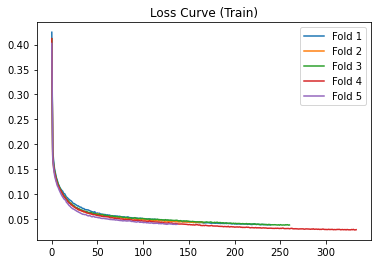

In [7]:
print('Validation Metrics')
score = kfold_validation(model,
                 x_train,
                 y_train,
                 random_state = grid.random_state,
                 scorer=neg_rmse,
                 norm_x=True,
                 norm_y=True,
                 n_folds=5, 
                 plot_loss=True,
                 add_bias=True,
                 print_metrics={
                    'RMSE': RMSE,
                    'MAE': MAE,
                    'MRE': MRE
                })
plt.title('Loss Curve (Train)');

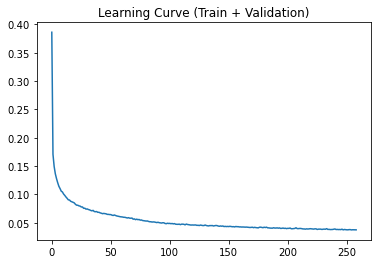

In [8]:
norm_x_train, norm_x, _  = standard_scaler(x_train)
norm_y_train, _, inv_norm = standard_scaler(y_train)

model.fit(norm_x_train, norm_y_train.ravel())
plt.title('Learning Curve (Train + Validation)')
plt.plot(model.loss_curve_);

In [9]:
norm_x_test = norm_x(x_test)

y_predict = model.predict(norm_x_test)
RMSE(inv_norm(y_predict), y_test)

print('Matrics (Train + Validation)')
print(f'RMSE: {RMSE(inv_norm(model.predict(norm_x_train)), y_train)}')
print(f'MAE: {MAE(inv_norm(model.predict(norm_x_train)), y_train)}')
print(f'MRE: {MRE(inv_norm(model.predict(norm_x_train)), y_train)}')

print('\nMetrics (Test)')
print(f'RMSE: {RMSE(inv_norm(y_predict), y_test)}')
print(f'MAE: {MAE(inv_norm(y_predict), y_test)}')
print(f'MRE: {MRE(inv_norm(y_predict), y_test)}')

Matrics (Train + Validation)
RMSE: 4.501564485656955
MAE: 3.4286436302725565
MRE: 0.12140620099170228

Metrics (Test)
RMSE: 5.593910113038309
MAE: 4.2195771800782085
MRE: 0.15823957102536457


## MLPClassifier - Vowels Dataset

In [10]:
vowels = np.genfromtxt('./vowel.csv', delimiter=',')
vowels_X = vowels[:, :-1]
vowels_Y = vowels[:, [-1]]

vowels_x_train, vowels_x_test, vowels_y_train, vowels_y_test = train_test_split(vowels_X, vowels_Y, test_size=.2)
vowels_x_train.shape, vowels_x_test.shape, vowels_X.shape, vowels_y_train.shape

((792, 10), (198, 10), (990, 10), (792, 1))

In [11]:
params = {
    'hidden_layer_sizes': (2, [6, 10]),
    'learning_rate_init': (10, [-2, -1]),
    'alpha': (10, [-5, -2]),
}

default_params = {
    'max_iter': 1000,
    'batch_size': 32,
    'solver': 'sgd',
    'momentum': .9,
    'shuffle': True,
    'activation': 'relu'
}

grid = RandomSearch(MLPClassifier, params, default_params, random_state=42)
grid.fit(vowels_x_train, vowels_y_train, n_iter=10, n_folds=5, norm_x=True, scorer=accurracy)
model = grid.best_estimator
grid.get_scores_()

,Score,Params
0,0.957081,"{'hidden_layer_sizes': 256, 'learning_rate_ini..."
1,0.958347,"{'hidden_layer_sizes': 256, 'learning_rate_ini..."
2,0.959613,"{'hidden_layer_sizes': 512, 'learning_rate_ini..."
3,0.955816,"{'hidden_layer_sizes': 64, 'learning_rate_init..."
4,0.955816,"{'hidden_layer_sizes': 128, 'learning_rate_ini..."
5,0.958347,"{'hidden_layer_sizes': 256, 'learning_rate_ini..."
6,0.957081,"{'hidden_layer_sizes': 256, 'learning_rate_ini..."
7,0.959613,"{'hidden_layer_sizes': 512, 'learning_rate_ini..."
8,0.957081,"{'hidden_layer_sizes': 128, 'learning_rate_ini..."
9,0.957081,"{'hidden_layer_sizes': 128, 'learning_rate_ini..."


Validation Metrics

Fold 1
accurracy: 0.9559748427672956

Fold 2
accurracy: 0.949685534591195

Fold 3
accurracy: 0.9746835443037974

Fold 4
accurracy: 0.9746835443037974

Fold 5
accurracy: 0.9430379746835443



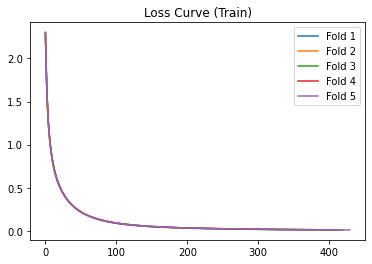

In [12]:
print('Validation Metrics\n')
kfold_validation(model,
                 vowels_x_train,
                 vowels_y_train,
                 scorer=accurracy,
                 random_state=grid.random_state,
                 norm_x=True,
                 n_folds=5, 
                 plot_loss=True,
                 print_metrics={
                     'accurracy': accurracy
                })
plt.title('Loss Curve (Train)');

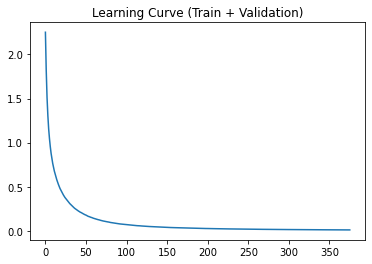

In [13]:
norm_x_train, norm_x, _  = standard_scaler(vowels_x_train)

model.fit(norm_x_train, vowels_y_train.ravel())
plt.title('Learning Curve (Train + Validation)')
plt.plot(model.loss_curve_);

In [14]:
norm_x_test = norm_x(vowels_x_test)

y_predict = model.predict(norm_x_test)

print('Matrics (Train + Validation)')
print(f'Accurracy: {accurracy(model.predict(norm_x_train), vowels_y_train)}')

print('\nMetrics (Test)')
print(f'Accurracy: {accurracy(y_predict, vowels_y_test)}')

Matrics (Train + Validation)
Accurracy: 1.0

Metrics (Test)
Accurracy: 0.9646464646464646
